In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib import learn
from sklearn import preprocessing
from sklearn import metrics
from __future__ import print_function
import itertools
from sklearn.linear_model import LinearRegression
import pandas as pd
from sklearn import model_selection
from sklearn_pandas import DataFrameMapper, cross_val_score
from sklearn_pandas import gen_features
from sklearn.pipeline import Pipeline
%matplotlib inline

In [2]:
scores = pd.read_csv('soretdScores.csv', lineterminator='\n')
data = pd.read_csv('motionData.csv', lineterminator='\n')
data.rename(columns={"FFPType\r": "FFPType"},inplace=True)

In [3]:
FEATURES = ["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration"]
FEATURESALL = ["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration", "FFPType"]
FEATURESALL_WTS = ["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration", "FFPType", "happier_wt", "sadder_wt", "angrier_wt", "more-afraid_wt"]

In [4]:
EMOSCORES = ["happier_mu", "sadder_mu", "angrier_mu", "more-afraid_mu"]
EMOCONFIDENCE_INV = ["happier_sigma", "sadder_sigma", "angrier_sigma", "more-afraid_sigma"]
min_confidence = 25/3 # true skill base confidence: http://trueskill.org/
WTS_LABEL = ["happier_wt", "sadder_wt", "angrier_wt", "more-afraid_wt"]

In [5]:
mapper = DataFrameMapper([
...     (["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration"], preprocessing.StandardScaler()),
...     (['FFPType'], None)], input_df = True)

In [6]:
transformedData = pd.DataFrame(mapper.fit_transform(data.copy()), columns=FEATURESALL)

In [7]:
transformedData["FFPType"] = transformedData["FFPType"].astype('int64')

In [8]:
WTS= {'happier_wt':(1.0-(scores[EMOCONFIDENCE_INV[0]]/min_confidence)).values,
                   'sadder_wt':(1.0-(scores[EMOCONFIDENCE_INV[1]]/min_confidence)).values,
                'angrier_wt':(1.0-(scores[EMOCONFIDENCE_INV[2]]/min_confidence)).values,
      'more-afraid_wt':(1.0-(scores[EMOCONFIDENCE_INV[3]]/min_confidence)).values}
WTS_df = pd.DataFrame(WTS,transformedData.index)
transformedData_WTS = pd.concat([transformedData, WTS_df], axis = 1)

In [9]:
 X_train, X_test, y_train, y_test = model_selection.train_test_split(transformedData_WTS, scores, test_size=0.2, random_state=42)

In [10]:
def get_input_fn(data_x,data_y, LABEL, num_epochs=None, shuffle=True):
  return tf.estimator.inputs.pandas_input_fn(
      x=pd.DataFrame({k: data_x[k].values for k in FEATURESALL_WTS}),
      y = pd.DataFrame(data_y[LABEL].values),
      num_epochs=num_epochs,
      shuffle=shuffle)

In [11]:
embedded_ffp_column = tf.contrib.layers.embedding_column(
    tf.contrib.layers.sparse_column_with_integerized_feature("FFPType", 7, combiner=None, dtype=tf.int64), dimension = 7)
one_hot_ffp = tf.feature_column.indicator_column(tf.contrib.layers.sparse_column_with_integerized_feature("FFPType", 7, combiner=None, dtype=tf.int64))

# Continuous columns- frontKneesAngle	rearKneesAngle	frontAnkle	rearAnkle	frontHipsAngle
bodyZ = tf.feature_column.numeric_column("bodyAngleZ")
frontK = tf.feature_column.numeric_column("frontKneesAngle")
rearK = tf.feature_column.numeric_column("rearKneesAngle")
frontA = tf.feature_column.numeric_column("frontAnkle")
rearA = tf.feature_column.numeric_column("rearAnkle")
frontH = tf.feature_column.numeric_column("frontHipsAngle")
rearH = tf.feature_column.numeric_column("rearHipsAngle")
swingFtHt = tf.feature_column.numeric_column("swingFtHeight")
speed = tf.feature_column.numeric_column("speed")
gaitTime = tf.feature_column.numeric_column("gaitDuration")

#feature_cols = [bodyZ, frontK, rearK, frontA, rearA, frontH, rearH, swingFtHt, speed, gaitTime, embedded_ffp_column]
feature_cols = [bodyZ, frontK, rearK, frontA, rearA, frontH, rearH, swingFtHt, speed, gaitTime, one_hot_ffp]

In [12]:
LABEL_ID = 0;
LABEL = EMOSCORES[LABEL_ID]
WT_COL = WTS_LABEL[LABEL_ID]

In [13]:
# Build DNN to recreate LR
model_dir_name="/DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data"

regressor = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols, hidden_units=[],  model_dir=model_dir_name, weight_column_name = WT_COL,
    optimizer = tf.train.AdamOptimizer(
      learning_rate=0.001), config=tf.contrib.learn.RunConfig(save_checkpoints_secs=1))

INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000000000E6C6B70>, '_log_step_count_steps': 100, '_task_id': 0, '_master': '', '_task_type': None, '_save_checkpoints_secs': 1, '_model_dir': '/DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data', '_environment': 'local', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_num_worker_replicas': 0, '_save_summary_steps': 100, '_num_ps_replicas': 0, '_session_config': None, '_evaluation_master': '', '_is_chief': True}


In [14]:
# Train.
regressor.fit(input_fn=get_input_fn(X_train, y_train, LABEL, num_epochs=None, shuffle=True),steps=200000) #2000000

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:step = 1, loss = 366.438
INFO:tensorflow:Saving checkpoints for 99 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 100 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 101 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 30.514
INFO:tensorflow:step = 101, loss = 350.528 (3.278 sec)
INFO:tensorflow:global_step/sec: 393.678
INFO:tensorflow:step = 201, l

INFO:tensorflow:Saving checkpoints for 2088 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2089 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 22.0397
INFO:tensorflow:step = 2101, loss = 248.114 (4.539 sec)
INFO:tensorflow:global_step/sec: 399.977
INFO:tensorflow:step = 2201, loss = 255.401 (0.250 sec)
INFO:tensorflow:Saving checkpoints for 2228 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2229 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2230 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2231 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2232 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2300 into /DNNNew/

INFO:tensorflow:Saving checkpoints for 4103 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 52.6009
INFO:tensorflow:step = 4201, loss = 151.169 (1.901 sec)
INFO:tensorflow:Saving checkpoints for 4250 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 4251 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 4252 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 26.8946
INFO:tensorflow:step = 4301, loss = 173.904 (3.718 sec)
INFO:tensorflow:Saving checkpoints for 4311 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 4356 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 4357 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 33.9309
INFO:tensorflow:

INFO:tensorflow:global_step/sec: 97.7461
INFO:tensorflow:step = 7001, loss = 104.122 (1.023 sec)
INFO:tensorflow:Saving checkpoints for 7015 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 7016 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 48.2831
INFO:tensorflow:step = 7101, loss = 100.748 (2.073 sec)
INFO:tensorflow:Saving checkpoints for 7195 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 7196 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 7197 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 29.6543
INFO:tensorflow:step = 7201, loss = 100.36 (3.368 sec)
INFO:tensorflow:Saving checkpoints for 7233 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 94.1566
INFO:tensorflow:step = 7301

INFO:tensorflow:step = 9801, loss = 51.3568 (7.678 sec)
INFO:tensorflow:Saving checkpoints for 9843 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 103.407
INFO:tensorflow:step = 9901, loss = 43.0549 (0.967 sec)
INFO:tensorflow:Saving checkpoints for 9954 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 9969 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 9970 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 32.9145
INFO:tensorflow:step = 10001, loss = 46.5892 (3.041 sec)
INFO:tensorflow:Saving checkpoints for 10031 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 99.3979
INFO:tensorflow:step = 10101, loss = 36.4616 (1.003 sec)
INFO:tensorflow:Saving checkpoints for 10144 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:te

INFO:tensorflow:Saving checkpoints for 12201 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 29.6016
INFO:tensorflow:step = 12201, loss = 26.1218 (3.378 sec)
INFO:tensorflow:Saving checkpoints for 12224 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 12292 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 51.4639
INFO:tensorflow:step = 12301, loss = 24.2472 (1.943 sec)
INFO:tensorflow:Saving checkpoints for 12343 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 12344 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 12345 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 12346 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 12347 int

INFO:tensorflow:step = 14701, loss = 12.3815 (2.937 sec)
INFO:tensorflow:global_step/sec: 446.403
INFO:tensorflow:step = 14801, loss = 12.8307 (0.224 sec)
INFO:tensorflow:Saving checkpoints for 14823 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 14824 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 14868 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 25.8316
INFO:tensorflow:step = 14901, loss = 14.51 (3.873 sec)
INFO:tensorflow:Saving checkpoints for 14973 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 14974 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 45.7221
INFO:tensorflow:step = 15001, loss = 11.5858 (2.185 sec)
INFO:tensorflow:Saving checkpoints for 15003 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INF

INFO:tensorflow:Saving checkpoints for 17337 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 28.0568
INFO:tensorflow:step = 17401, loss = 11.3399 (3.565 sec)
INFO:tensorflow:Saving checkpoints for 17402 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 17463 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 17464 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 17465 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 22.9608
INFO:tensorflow:step = 17501, loss = 12.6026 (4.354 sec)
INFO:tensorflow:Saving checkpoints for 17533 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 95.0516
INFO:tensorflow:step = 17601, loss = 10.3617 (1.052 sec)
INFO:tensorflow:Saving checkpoints for 17611 into /DNNNew/

INFO:tensorflow:Saving checkpoints for 19642 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 19690 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 34.6241
INFO:tensorflow:step = 19701, loss = 9.51715 (2.887 sec)
INFO:tensorflow:Saving checkpoints for 19766 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 88.5689
INFO:tensorflow:step = 19801, loss = 9.53366 (1.128 sec)
INFO:tensorflow:Saving checkpoints for 19811 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 19812 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 19813 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 19814 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 21.6344
INFO:te

INFO:tensorflow:Saving checkpoints for 22207 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 22208 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 22212 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 22213 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 22289 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 22290 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 22291 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 10.7915
INFO:tensorflow:step = 22301, loss = 10.9804 (9.265 sec)
INFO:tensorflow:Saving checkpoints for 22354 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for

INFO:tensorflow:global_step/sec: 103.621
INFO:tensorflow:step = 24801, loss = 8.74776 (0.965 sec)
INFO:tensorflow:Saving checkpoints for 24881 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 84.2412
INFO:tensorflow:step = 24901, loss = 9.67851 (1.185 sec)
INFO:tensorflow:Saving checkpoints for 24910 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 24988 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 53.3587
INFO:tensorflow:step = 25001, loss = 9.93275 (1.875 sec)
INFO:tensorflow:Saving checkpoints for 25071 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 25077 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 25078 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 31.8352
INFO:tensorflow:s

INFO:tensorflow:global_step/sec: 92.3308
INFO:tensorflow:step = 27601, loss = 12.6222 (1.083 sec)
INFO:tensorflow:Saving checkpoints for 27661 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 27662 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 36.2167
INFO:tensorflow:step = 27701, loss = 8.58656 (2.761 sec)
INFO:tensorflow:Saving checkpoints for 27768 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 97.1762
INFO:tensorflow:step = 27801, loss = 11.2393 (1.029 sec)
INFO:tensorflow:Saving checkpoints for 27855 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 27856 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 27857 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 27858 into /DNNNew/

INFO:tensorflow:Saving checkpoints for 29961 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 29962 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 29964 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 23.8422
INFO:tensorflow:step = 30001, loss = 8.81223 (4.195 sec)
INFO:tensorflow:Saving checkpoints for 30017 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 30018 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 30090 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 30.6167
INFO:tensorflow:step = 30101, loss = 12.1094 (3.265 sec)
INFO:tensorflow:global_step/sec: 462.937
INFO:tensorflow:step = 30201, loss = 10.0421 (0.215 sec)
INFO:tensorflow:Saving checkpoints for 30214 into /DNNNew/

INFO:tensorflow:global_step/sec: 31.2873
INFO:tensorflow:step = 31501, loss = 8.34562 (3.198 sec)
INFO:tensorflow:global_step/sec: 414.914
INFO:tensorflow:step = 31601, loss = 9.88097 (0.242 sec)
INFO:tensorflow:Saving checkpoints for 31602 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 31668 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 31669 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 31694 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 20.5411
INFO:tensorflow:step = 31701, loss = 11.655 (4.867 sec)
INFO:tensorflow:Saving checkpoints for 31702 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 31739 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 31750 into /DNNNew/D

INFO:tensorflow:Saving checkpoints for 32513 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 32514 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 32515 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 32516 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 32517 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 32518 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 32519 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 32520 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 32521 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving check

INFO:tensorflow:global_step/sec: 14.8668
INFO:tensorflow:step = 33601, loss = 8.90909 (6.726 sec)
INFO:tensorflow:Saving checkpoints for 33654 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 119.041
INFO:tensorflow:step = 33701, loss = 10.2922 (0.840 sec)
INFO:tensorflow:global_step/sec: 350.857
INFO:tensorflow:step = 33801, loss = 9.83934 (0.283 sec)
INFO:tensorflow:Saving checkpoints for 33804 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 33805 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 33806 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 33832 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 19.3114
INFO:tensorflow:step = 33901, loss = 8.95813 (5.180 sec)
INFO:tensorflow:Saving checkpoints for 33922 into /DNNNew/DNNHappy/h

INFO:tensorflow:Saving checkpoints for 35885 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 35886 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 35887 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 19.6955
INFO:tensorflow:step = 35901, loss = 9.73507 (5.078 sec)
INFO:tensorflow:Saving checkpoints for 35928 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 35929 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 35979 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 35980 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 35981 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for

INFO:tensorflow:global_step/sec: 48.8253
INFO:tensorflow:step = 37901, loss = 10.1994 (2.048 sec)
INFO:tensorflow:Saving checkpoints for 37960 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 89.4403
INFO:tensorflow:step = 38001, loss = 8.23679 (1.120 sec)
INFO:tensorflow:Saving checkpoints for 38005 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 38008 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 38022 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 38051 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 38052 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 38053 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 38054 int

INFO:tensorflow:Saving checkpoints for 39984 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 39985 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 39986 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 20.478
INFO:tensorflow:step = 40001, loss = 9.65326 (4.884 sec)
INFO:tensorflow:global_step/sec: 473.906
INFO:tensorflow:step = 40101, loss = 9.93427 (0.211 sec)
INFO:tensorflow:Saving checkpoints for 40160 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 120.33
INFO:tensorflow:step = 40201, loss = 9.26754 (0.830 sec)
INFO:tensorflow:global_step/sec: 510.175
INFO:tensorflow:step = 40301, loss = 9.58405 (0.197 sec)
INFO:tensorflow:Saving checkpoints for 40353 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 40382 into /DNNNew/DNNHappy/hap

INFO:tensorflow:Saving checkpoints for 42850 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 50.1224
INFO:tensorflow:step = 42901, loss = 10.6722 (1.993 sec)
INFO:tensorflow:Saving checkpoints for 42939 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 94.2453
INFO:tensorflow:step = 43001, loss = 10.2214 (1.062 sec)
INFO:tensorflow:Saving checkpoints for 43018 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 43019 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 43056 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 31.5042
INFO:tensorflow:step = 43101, loss = 9.54652 (3.174 sec)
INFO:tensorflow:Saving checkpoints for 43166 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 94.1566
INFO:tensorflow:s

INFO:tensorflow:step = 45501, loss = 10.2181 (2.043 sec)
INFO:tensorflow:Saving checkpoints for 45579 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 82.7767
INFO:tensorflow:step = 45601, loss = 9.38342 (1.209 sec)
INFO:tensorflow:Saving checkpoints for 45602 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 45609 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 45610 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 45611 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 45636 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 45668 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 45669 into /DNNNew/DNNHappy/happy_DNNRecreateLR_80

INFO:tensorflow:global_step/sec: 24.0025
INFO:tensorflow:step = 47701, loss = 9.47277 (4.167 sec)
INFO:tensorflow:Saving checkpoints for 47736 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 47737 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 47785 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 47786 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 22.7726
INFO:tensorflow:step = 47801, loss = 12.088 (4.392 sec)
INFO:tensorflow:Saving checkpoints for 47876 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 86.1277
INFO:tensorflow:step = 47901, loss = 8.62961 (1.161 sec)
INFO:tensorflow:Saving checkpoints for 47909 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 105.926
INFO:tensorflow:st

INFO:tensorflow:Saving checkpoints for 50600 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 52.6009
INFO:tensorflow:step = 50601, loss = 8.73935 (1.900 sec)
INFO:tensorflow:Saving checkpoints for 50669 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 50693 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 47.8671
INFO:tensorflow:step = 50701, loss = 9.06292 (2.089 sec)
INFO:tensorflow:Saving checkpoints for 50718 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 50746 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 53.0474
INFO:tensorflow:step = 50801, loss = 9.57432 (1.887 sec)
INFO:tensorflow:Saving checkpoints for 50865 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 50871 into /DNNNew/

INFO:tensorflow:global_step/sec: 15.8369
INFO:tensorflow:step = 53201, loss = 10.7977 (6.314 sec)
INFO:tensorflow:Saving checkpoints for 53230 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 123.45
INFO:tensorflow:step = 53301, loss = 8.88645 (0.810 sec)
INFO:tensorflow:global_step/sec: 413.199
INFO:tensorflow:step = 53401, loss = 9.97615 (0.242 sec)
INFO:tensorflow:Saving checkpoints for 53404 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 99.1024
INFO:tensorflow:step = 53501, loss = 10.6477 (1.009 sec)
INFO:tensorflow:Saving checkpoints for 53502 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 53514 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 53515 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 32.6565
INFO:tensorflow:step = 53601

INFO:tensorflow:Saving checkpoints for 55597 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 55598 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 8.12037
INFO:tensorflow:step = 55601, loss = 10.6347 (12.315 sec)
INFO:tensorflow:global_step/sec: 456.595
INFO:tensorflow:step = 55701, loss = 8.09382 (0.221 sec)
INFO:tensorflow:Saving checkpoints for 55714 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 55715 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 55765 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 55766 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 55767 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 55768 in

INFO:tensorflow:Saving checkpoints for 57384 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 57400 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 50.707
INFO:tensorflow:step = 57401, loss = 12.6167 (1.929 sec)
INFO:tensorflow:global_step/sec: 490.169
INFO:tensorflow:step = 57501, loss = 8.99881 (0.205 sec)
INFO:tensorflow:Saving checkpoints for 57524 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 57569 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 53.3872
INFO:tensorflow:step = 57601, loss = 9.63778 (1.873 sec)
INFO:tensorflow:Saving checkpoints for 57687 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 57688 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 44.7002
INFO:tensorflow:st

INFO:tensorflow:Saving checkpoints for 60219 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 60267 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 50.8877
INFO:tensorflow:step = 60301, loss = 10.814 (1.964 sec)
INFO:tensorflow:Saving checkpoints for 60345 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 60346 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 60347 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 29.6983
INFO:tensorflow:step = 60401, loss = 8.54507 (3.368 sec)
INFO:tensorflow:Saving checkpoints for 60461 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 103.193
INFO:tensorflow:step = 60501, loss = 8.5547 (0.968 sec)
INFO:tensorflow:Saving checkpoints for 60562 into /DNNNew/DN

INFO:tensorflow:global_step/sec: 58.5104
INFO:tensorflow:step = 62801, loss = 10.5907 (1.707 sec)
INFO:tensorflow:global_step/sec: 416.643
INFO:tensorflow:step = 62901, loss = 9.45374 (0.242 sec)
INFO:tensorflow:Saving checkpoints for 62925 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 62969 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 62970 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 62971 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 62972 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 62973 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 62974 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 62975 int

INFO:tensorflow:global_step/sec: 93.4526
INFO:tensorflow:step = 65501, loss = 10.457 (1.070 sec)
INFO:tensorflow:Saving checkpoints for 65523 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 65532 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 65533 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 65534 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 65535 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 16.8369
INFO:tensorflow:step = 65601, loss = 10.9069 (5.938 sec)
INFO:tensorflow:Saving checkpoints for 65611 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 65612 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 65686 into

INFO:tensorflow:global_step/sec: 93.9796
INFO:tensorflow:step = 68501, loss = 9.03934 (1.066 sec)
INFO:tensorflow:Saving checkpoints for 68522 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 117.089
INFO:tensorflow:step = 68601, loss = 8.67489 (0.854 sec)
INFO:tensorflow:Saving checkpoints for 68678 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 105.702
INFO:tensorflow:step = 68701, loss = 11.6243 (0.946 sec)
INFO:tensorflow:global_step/sec: 421.916
INFO:tensorflow:step = 68801, loss = 10.3804 (0.237 sec)
INFO:tensorflow:Saving checkpoints for 68803 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 68860 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 49.6989
INFO:tensorflow:step = 68901, loss = 8.33695 (2.011 sec)
INFO:tensorflow:Saving checkpoints for 68902 into /DNNNew/DNNHappy/happy_DNNRe

INFO:tensorflow:Saving checkpoints for 71594 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 111.976
INFO:tensorflow:step = 71601, loss = 9.83273 (0.893 sec)
INFO:tensorflow:global_step/sec: 497.484
INFO:tensorflow:step = 71701, loss = 8.9683 (0.202 sec)
INFO:tensorflow:Saving checkpoints for 71737 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 105.702
INFO:tensorflow:step = 71801, loss = 8.48423 (0.946 sec)
INFO:tensorflow:Saving checkpoints for 71875 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 118.477
INFO:tensorflow:step = 71901, loss = 7.75225 (0.844 sec)
INFO:tensorflow:global_step/sec: 480.742
INFO:tensorflow:step = 72001, loss = 9.04954 (0.207 sec)
INFO:tensorflow:Saving checkpoints for 72045 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 72046 into /DNNNew/DNNHappy/happy_DNNRec

INFO:tensorflow:step = 75301, loss = 8.95827 (0.263 sec)
INFO:tensorflow:Saving checkpoints for 75338 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 75339 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 75340 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 31.0831
INFO:tensorflow:step = 75401, loss = 10.3387 (3.217 sec)
INFO:tensorflow:Saving checkpoints for 75404 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 75496 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 51.1218
INFO:tensorflow:step = 75501, loss = 9.6405 (1.955 sec)
INFO:tensorflow:Saving checkpoints for 75527 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 75573 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\mode

INFO:tensorflow:Saving checkpoints for 78961 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 100.295
INFO:tensorflow:step = 79001, loss = 10.1492 (0.997 sec)
INFO:tensorflow:Saving checkpoints for 79064 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 102.664
INFO:tensorflow:step = 79101, loss = 7.26289 (0.974 sec)
INFO:tensorflow:Saving checkpoints for 79190 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 101.414
INFO:tensorflow:step = 79201, loss = 11.2924 (0.986 sec)
INFO:tensorflow:Saving checkpoints for 79298 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 100.902
INFO:tensorflow:step = 79301, loss = 11.1247 (0.990 sec)
INFO:tensorflow:global_step/sec: 467.263
INFO:tensorflow:step = 79401, loss = 8.8364 (0.215 sec)
INFO:tensorflow:Saving checkpoints for 79404 into /DNNNew/DNNHappy/happy_DNNRec

INFO:tensorflow:global_step/sec: 98.0336
INFO:tensorflow:step = 82501, loss = 10.2934 (1.019 sec)
INFO:tensorflow:Saving checkpoints for 82551 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 102.348
INFO:tensorflow:step = 82601, loss = 8.89498 (0.977 sec)
INFO:tensorflow:Saving checkpoints for 82664 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 103.407
INFO:tensorflow:step = 82701, loss = 8.89109 (0.968 sec)
INFO:tensorflow:Saving checkpoints for 82774 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 108.336
INFO:tensorflow:step = 82801, loss = 10.5978 (0.924 sec)
INFO:tensorflow:global_step/sec: 446.403
INFO:tensorflow:step = 82901, loss = 9.97804 (0.223 sec)
INFO:tensorflow:Saving checkpoints for 82905 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 116.679
INFO:tensorflow:step = 83001, loss = 

INFO:tensorflow:Saving checkpoints for 86157 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 53.0755
INFO:tensorflow:step = 86201, loss = 10.3856 (1.883 sec)
INFO:tensorflow:Saving checkpoints for 86246 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 86293 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 49.0408
INFO:tensorflow:step = 86301, loss = 9.74549 (2.038 sec)
INFO:tensorflow:Saving checkpoints for 86338 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 98.2262
INFO:tensorflow:step = 86401, loss = 9.46747 (1.020 sec)
INFO:tensorflow:Saving checkpoints for 86438 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 102.875
INFO:tensorflow:step = 86501, loss = 10.7973 (0.971 sec)
INFO:tensorflow:Saving checkpoints for 86542 into /DNNNew/DNNHappy/h

INFO:tensorflow:global_step/sec: 103.087
INFO:tensorflow:step = 89201, loss = 10.9237 (0.969 sec)
INFO:tensorflow:Saving checkpoints for 89233 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 89234 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 49.6496
INFO:tensorflow:step = 89301, loss = 10.4321 (2.015 sec)
INFO:tensorflow:Saving checkpoints for 89375 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 120.33
INFO:tensorflow:step = 89401, loss = 7.96684 (0.830 sec)
INFO:tensorflow:global_step/sec: 423.705
INFO:tensorflow:step = 89501, loss = 10.2964 (0.237 sec)
INFO:tensorflow:Saving checkpoints for 89554 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 102.244
INFO:tensorflow:step = 89601, loss = 10.3307 (0.976 sec)
INFO:tensorflow:Saving checkpoints for 89671 into /DNNNew/DNNHappy/happy_DNNRec

INFO:tensorflow:global_step/sec: 99.5959
INFO:tensorflow:step = 92001, loss = 10.0765 (1.006 sec)
INFO:tensorflow:Saving checkpoints for 92049 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 107.06
INFO:tensorflow:step = 92101, loss = 9.1434 (0.934 sec)
INFO:tensorflow:Saving checkpoints for 92181 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 106.49
INFO:tensorflow:step = 92201, loss = 10.8845 (0.938 sec)
INFO:tensorflow:global_step/sec: 483.064
INFO:tensorflow:step = 92301, loss = 10.6403 (0.208 sec)
INFO:tensorflow:Saving checkpoints for 92311 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 114.149
INFO:tensorflow:step = 92401, loss = 8.07074 (0.876 sec)
INFO:tensorflow:Saving checkpoints for 92456 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 104.161
INFO:tensorflow:step = 92501, loss = 8.7

INFO:tensorflow:global_step/sec: 34.1978
INFO:tensorflow:step = 95801, loss = 12.1796 (2.921 sec)
INFO:tensorflow:Saving checkpoints for 95841 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 95871 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 95872 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 30.8149
INFO:tensorflow:step = 95901, loss = 9.17307 (3.244 sec)
INFO:tensorflow:Saving checkpoints for 95916 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 100.195
INFO:tensorflow:step = 96001, loss = 8.7109 (0.999 sec)
INFO:tensorflow:Saving checkpoints for 96013 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 115.201
INFO:tensorflow:step = 96101, loss = 7.67116 (0.867 sec)
INFO:tensorflow:Saving checkpoints for 96171 into /DNNNew/DNNHappy/ha

INFO:tensorflow:step = 99501, loss = 10.8413 (0.792 sec)
INFO:tensorflow:global_step/sec: 499.971
INFO:tensorflow:step = 99601, loss = 9.26904 (0.202 sec)
INFO:tensorflow:Saving checkpoints for 99682 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 99.6952
INFO:tensorflow:step = 99701, loss = 9.33472 (1.001 sec)
INFO:tensorflow:Saving checkpoints for 99775 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 119.61
INFO:tensorflow:step = 99801, loss = 7.42391 (0.837 sec)
INFO:tensorflow:global_step/sec: 476.163
INFO:tensorflow:step = 99901, loss = 9.29063 (0.210 sec)
INFO:tensorflow:Saving checkpoints for 99951 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 103.514
INFO:tensorflow:step = 100001, loss = 10.3773 (0.966 sec)
INFO:tensorflow:Saving checkpoints for 100073 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:glob

INFO:tensorflow:step = 103201, loss = 10.4504 (0.965 sec)
INFO:tensorflow:global_step/sec: 476.163
INFO:tensorflow:step = 103301, loss = 9.60193 (0.209 sec)
INFO:tensorflow:Saving checkpoints for 103321 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 103361 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 51.3845
INFO:tensorflow:step = 103401, loss = 9.75741 (1.945 sec)
INFO:tensorflow:Saving checkpoints for 103459 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 103463 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 51.9721
INFO:tensorflow:step = 103501, loss = 10.232 (1.925 sec)
INFO:tensorflow:Saving checkpoints for 103597 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 100.094
INFO:tensorflow:step = 103601, loss = 8.85095 (0.998 sec)
IN

INFO:tensorflow:Saving checkpoints for 106543 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 102.875
INFO:tensorflow:step = 106601, loss = 9.91136 (0.971 sec)
INFO:tensorflow:Saving checkpoints for 106654 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 113.63
INFO:tensorflow:step = 106701, loss = 8.46902 (0.882 sec)
INFO:tensorflow:global_step/sec: 487.777
INFO:tensorflow:step = 106801, loss = 10.2322 (0.206 sec)
INFO:tensorflow:Saving checkpoints for 106813 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 111.601
INFO:tensorflow:step = 106901, loss = 10.457 (0.895 sec)
INFO:tensorflow:Saving checkpoints for 106960 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 110.613
INFO:tensorflow:step = 107001, loss = 9.85474 (0.902 sec)
INFO:tensorflow:global_step/sec: 421.917
INFO:tensorflow:step = 107101,

INFO:tensorflow:Saving checkpoints for 111102 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 121.5
INFO:tensorflow:step = 111201, loss = 8.39399 (0.823 sec)
INFO:tensorflow:Saving checkpoints for 111278 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 129.694
INFO:tensorflow:step = 111301, loss = 8.01534 (0.771 sec)
INFO:tensorflow:global_step/sec: 401.584
INFO:tensorflow:step = 111401, loss = 10.2984 (0.249 sec)
INFO:tensorflow:Saving checkpoints for 111469 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 111.228
INFO:tensorflow:step = 111501, loss = 8.77881 (0.897 sec)
INFO:tensorflow:global_step/sec: 480.742
INFO:tensorflow:step = 111601, loss = 8.90685 (0.210 sec)
INFO:tensorflow:Saving checkpoints for 111624 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 107.521
INFO:tensorflow:step = 111701,

INFO:tensorflow:global_step/sec: 117.089
INFO:tensorflow:step = 116001, loss = 9.36749 (0.853 sec)
INFO:tensorflow:global_step/sec: 427.326
INFO:tensorflow:step = 116101, loss = 10.0561 (0.235 sec)
INFO:tensorflow:Saving checkpoints for 116149 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 119.897
INFO:tensorflow:step = 116201, loss = 9.36315 (0.834 sec)
INFO:tensorflow:global_step/sec: 399.977
INFO:tensorflow:step = 116301, loss = 9.53359 (0.250 sec)
INFO:tensorflow:Saving checkpoints for 116314 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 123.146
INFO:tensorflow:step = 116401, loss = 10.7005 (0.811 sec)
INFO:tensorflow:Saving checkpoints for 116488 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 116.137
INFO:tensorflow:step = 116501, loss = 8.67823 (0.861 sec)
INFO:tensorflow:global_step/sec: 390.603
INFO:tensorflow:step = 116601, loss = 

INFO:tensorflow:global_step/sec: 112.988
INFO:tensorflow:step = 120901, loss = 10.1882 (0.885 sec)
INFO:tensorflow:global_step/sec: 476.163
INFO:tensorflow:step = 121001, loss = 9.08123 (0.210 sec)
INFO:tensorflow:Saving checkpoints for 121020 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 102.664
INFO:tensorflow:step = 121101, loss = 9.76864 (0.973 sec)
INFO:tensorflow:Saving checkpoints for 121130 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 133.682
INFO:tensorflow:step = 121201, loss = 11.5047 (0.749 sec)
INFO:tensorflow:global_step/sec: 502.484
INFO:tensorflow:step = 121301, loss = 11.458 (0.199 sec)
INFO:tensorflow:Saving checkpoints for 121358 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 114.804
INFO:tensorflow:step = 121401, loss = 9.35176 (0.871 sec)
INFO:tensorflow:global_step/sec: 483.064
INFO:tensorflow:step = 121501, loss = 1

INFO:tensorflow:global_step/sec: 114.019
INFO:tensorflow:step = 125901, loss = 9.84252 (0.877 sec)
INFO:tensorflow:Saving checkpoints for 125962 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 111.976
INFO:tensorflow:step = 126001, loss = 9.44573 (0.895 sec)
INFO:tensorflow:global_step/sec: 427.326
INFO:tensorflow:step = 126101, loss = 7.58908 (0.232 sec)
INFO:tensorflow:Saving checkpoints for 126102 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 129.526
INFO:tensorflow:step = 126201, loss = 10.6294 (0.773 sec)
INFO:tensorflow:global_step/sec: 442.453
INFO:tensorflow:step = 126301, loss = 9.10542 (0.225 sec)
INFO:tensorflow:Saving checkpoints for 126303 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 126393 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 55.5524
INFO:tensorflow:step = 12640

INFO:tensorflow:global_step/sec: 483.064
INFO:tensorflow:step = 130801, loss = 10.5506 (0.207 sec)
INFO:tensorflow:Saving checkpoints for 130847 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 141.836
INFO:tensorflow:step = 130901, loss = 12.3179 (0.704 sec)
INFO:tensorflow:global_step/sec: 392.134
INFO:tensorflow:step = 131001, loss = 10.1039 (0.255 sec)
INFO:tensorflow:Saving checkpoints for 131062 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 111.228
INFO:tensorflow:step = 131101, loss = 9.08278 (0.899 sec)
INFO:tensorflow:global_step/sec: 520.804
INFO:tensorflow:step = 131201, loss = 9.48745 (0.191 sec)
INFO:tensorflow:Saving checkpoints for 131228 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 136.232
INFO:tensorflow:step = 131301, loss = 8.7354 (0.735 sec)
INFO:tensorflow:global_step/sec: 420.144
INFO:tensorflow:step = 131401, loss = 9

INFO:tensorflow:Saving checkpoints for 135536 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 119.183
INFO:tensorflow:step = 135601, loss = 10.4779 (0.839 sec)
INFO:tensorflow:Saving checkpoints for 135691 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 131.745
INFO:tensorflow:step = 135701, loss = 9.10204 (0.759 sec)
INFO:tensorflow:global_step/sec: 483.064
INFO:tensorflow:step = 135801, loss = 10.5196 (0.207 sec)
INFO:tensorflow:global_step/sec: 425.508
INFO:tensorflow:step = 135901, loss = 13.6155 (0.235 sec)
INFO:tensorflow:Saving checkpoints for 135911 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 109.884
INFO:tensorflow:step = 136001, loss = 11.2263 (0.910 sec)
INFO:tensorflow:Saving checkpoints for 136060 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 113.889
INFO:tensorflow:step = 13610

INFO:tensorflow:global_step/sec: 358.402
INFO:tensorflow:step = 140301, loss = 10.9705 (0.281 sec)
INFO:tensorflow:Saving checkpoints for 140331 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 108.454
INFO:tensorflow:step = 140401, loss = 7.73601 (0.922 sec)
INFO:tensorflow:Saving checkpoints for 140500 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 120.475
INFO:tensorflow:step = 140501, loss = 10.965 (0.829 sec)
INFO:tensorflow:global_step/sec: 478.441
INFO:tensorflow:step = 140601, loss = 8.77425 (0.210 sec)
INFO:tensorflow:Saving checkpoints for 140680 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 119.61
INFO:tensorflow:step = 140701, loss = 11.5921 (0.836 sec)
INFO:tensorflow:global_step/sec: 495.022
INFO:tensorflow:step = 140801, loss = 10.1333 (0.201 sec)
INFO:tensorflow:Saving checkpoints for 140861 into /DNNNew/DNNHappy/happy_DNNRecr

INFO:tensorflow:Saving checkpoints for 145218 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 117.918
INFO:tensorflow:step = 145301, loss = 7.79561 (0.846 sec)
INFO:tensorflow:Saving checkpoints for 145390 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 95.2327
INFO:tensorflow:step = 145401, loss = 9.72858 (1.050 sec)
INFO:tensorflow:Saving checkpoints for 145464 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 145499 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 55.8315
INFO:tensorflow:step = 145501, loss = 9.69952 (1.791 sec)
INFO:tensorflow:global_step/sec: 381.658
INFO:tensorflow:step = 145601, loss = 9.103 (0.263 sec)
INFO:tensorflow:Saving checkpoints for 145637 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 91.4861
INFO:tensorflow:step

INFO:tensorflow:global_step/sec: 113.63
INFO:tensorflow:step = 149901, loss = 9.61321 (0.880 sec)
INFO:tensorflow:global_step/sec: 490.168
INFO:tensorflow:step = 150001, loss = 8.18104 (0.204 sec)
INFO:tensorflow:Saving checkpoints for 150057 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 115.6
INFO:tensorflow:step = 150101, loss = 7.92868 (0.864 sec)
INFO:tensorflow:global_step/sec: 523.53
INFO:tensorflow:step = 150201, loss = 7.73639 (0.191 sec)
INFO:tensorflow:Saving checkpoints for 150226 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 118.057
INFO:tensorflow:step = 150301, loss = 11.2883 (0.848 sec)
INFO:tensorflow:global_step/sec: 520.804
INFO:tensorflow:step = 150401, loss = 10.4915 (0.193 sec)
INFO:tensorflow:Saving checkpoints for 150406 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 113.244
INFO:tensorflow:step = 150501, loss = 12.1

INFO:tensorflow:Saving checkpoints for 154943 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 131.399
INFO:tensorflow:step = 155001, loss = 10.7324 (0.759 sec)
INFO:tensorflow:global_step/sec: 480.741
INFO:tensorflow:step = 155101, loss = 9.20576 (0.209 sec)
INFO:tensorflow:Saving checkpoints for 155161 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 155197 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 56.5259
INFO:tensorflow:step = 155201, loss = 10.0137 (1.768 sec)
INFO:tensorflow:global_step/sec: 456.594
INFO:tensorflow:step = 155301, loss = 10.2889 (0.219 sec)
INFO:tensorflow:Saving checkpoints for 155367 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 125.149
INFO:tensorflow:step = 155401, loss = 8.94403 (0.800 sec)
INFO:tensorflow:global_step/sec: 450.425
INFO:tensorflow:step = 15550

INFO:tensorflow:step = 159501, loss = 11.7862 (0.233 sec)
INFO:tensorflow:Saving checkpoints for 159514 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 124.993
INFO:tensorflow:step = 159601, loss = 10.0458 (0.801 sec)
INFO:tensorflow:Saving checkpoints for 159700 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 112.101
INFO:tensorflow:step = 159701, loss = 9.48775 (0.892 sec)
INFO:tensorflow:global_step/sec: 444.419
INFO:tensorflow:step = 159801, loss = 10.0021 (0.225 sec)
INFO:tensorflow:Saving checkpoints for 159859 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 124.837
INFO:tensorflow:step = 159901, loss = 9.84837 (0.801 sec)
INFO:tensorflow:global_step/sec: 505.021
INFO:tensorflow:step = 160001, loss = 7.978 (0.198 sec)
INFO:tensorflow:Saving checkpoints for 160058 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorfl

INFO:tensorflow:global_step/sec: 134.582
INFO:tensorflow:step = 164301, loss = 7.93916 (0.743 sec)
INFO:tensorflow:global_step/sec: 450.425
INFO:tensorflow:step = 164401, loss = 10.0205 (0.222 sec)
INFO:tensorflow:global_step/sec: 418.386
INFO:tensorflow:step = 164501, loss = 10.2512 (0.239 sec)
INFO:tensorflow:Saving checkpoints for 164504 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 129.192
INFO:tensorflow:step = 164601, loss = 8.98616 (0.773 sec)
INFO:tensorflow:Saving checkpoints for 164697 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 120.766
INFO:tensorflow:step = 164701, loss = 10.2703 (0.827 sec)
INFO:tensorflow:global_step/sec: 502.484
INFO:tensorflow:step = 164801, loss = 9.4915 (0.202 sec)
INFO:tensorflow:Saving checkpoints for 164886 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 121.352
INFO:tensorflow:step = 164901, loss = 9

INFO:tensorflow:global_step/sec: 122.843
INFO:tensorflow:step = 169301, loss = 9.39343 (0.813 sec)
INFO:tensorflow:global_step/sec: 515.435
INFO:tensorflow:step = 169401, loss = 9.98283 (0.193 sec)
INFO:tensorflow:Saving checkpoints for 169408 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 117.364
INFO:tensorflow:step = 169501, loss = 11.4268 (0.855 sec)
INFO:tensorflow:Saving checkpoints for 169558 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 169559 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 43.2501
INFO:tensorflow:step = 169601, loss = 11.4348 (2.310 sec)
INFO:tensorflow:Saving checkpoints for 169642 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 119.041
INFO:tensorflow:step = 169701, loss = 9.88266 (0.840 sec)
INFO:tensorflow:global_step/sec: 490.168
INFO:tensorflow:step = 16980

INFO:tensorflow:global_step/sec: 460.803
INFO:tensorflow:step = 174101, loss = 9.2846 (0.217 sec)
INFO:tensorflow:Saving checkpoints for 174153 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 99.8944
INFO:tensorflow:step = 174201, loss = 8.54154 (1.002 sec)
INFO:tensorflow:Saving checkpoints for 174252 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 112.988
INFO:tensorflow:step = 174301, loss = 9.71694 (0.883 sec)
INFO:tensorflow:Saving checkpoints for 174388 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 99.0042
INFO:tensorflow:step = 174401, loss = 9.84304 (1.009 sec)
INFO:tensorflow:Saving checkpoints for 174497 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 115.334
INFO:tensorflow:step = 174501, loss = 9.7145 (0.867 sec)
INFO:tensorflow:global_step/sec: 483.064
INFO:tensorflow:step = 174601,

INFO:tensorflow:step = 178301, loss = 10.9193 (0.755 sec)
INFO:tensorflow:global_step/sec: 404.835
INFO:tensorflow:step = 178401, loss = 10.5164 (0.248 sec)
INFO:tensorflow:Saving checkpoints for 178456 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 117.918
INFO:tensorflow:step = 178501, loss = 9.11684 (0.848 sec)
INFO:tensorflow:global_step/sec: 434.758
INFO:tensorflow:step = 178601, loss = 9.91708 (0.230 sec)
INFO:tensorflow:Saving checkpoints for 178625 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 178678 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 59.5204
INFO:tensorflow:step = 178701, loss = 9.66483 (1.680 sec)
INFO:tensorflow:global_step/sec: 469.457
INFO:tensorflow:step = 178801, loss = 11.1361 (0.213 sec)
INFO:tensorflow:Saving checkpoints for 178887 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensor

INFO:tensorflow:step = 183301, loss = 9.16249 (0.332 sec)
INFO:tensorflow:Saving checkpoints for 183343 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 99.7947
INFO:tensorflow:step = 183401, loss = 7.86318 (1.003 sec)
INFO:tensorflow:Saving checkpoints for 183458 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 129.359
INFO:tensorflow:step = 183501, loss = 11.9807 (0.773 sec)
INFO:tensorflow:global_step/sec: 413.2
INFO:tensorflow:step = 183601, loss = 8.70443 (0.242 sec)
INFO:tensorflow:Saving checkpoints for 183642 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 106.49
INFO:tensorflow:step = 183701, loss = 9.20725 (0.937 sec)
INFO:tensorflow:Saving checkpoints for 183746 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 121.5
INFO:tensorflow:step = 183801, loss = 9.38418 (0.824 sec)
INFO:tensorflow:

INFO:tensorflow:step = 188301, loss = 9.34639 (0.231 sec)
INFO:tensorflow:Saving checkpoints for 188308 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 188401 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 60.4195
INFO:tensorflow:step = 188401, loss = 11.0676 (1.653 sec)
INFO:tensorflow:global_step/sec: 393.678
INFO:tensorflow:step = 188501, loss = 9.41791 (0.254 sec)
INFO:tensorflow:Saving checkpoints for 188538 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 115.467
INFO:tensorflow:step = 188601, loss = 12.6187 (0.867 sec)
INFO:tensorflow:global_step/sec: 416.643
INFO:tensorflow:step = 188701, loss = 8.12289 (0.239 sec)
INFO:tensorflow:Saving checkpoints for 188703 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 128.034
INFO:tensorflow:step = 188801, loss = 10.0565 (0.782 sec)
INFO:tensor

INFO:tensorflow:global_step/sec: 121.5
INFO:tensorflow:step = 193101, loss = 11.0038 (0.824 sec)
INFO:tensorflow:global_step/sec: 485.409
INFO:tensorflow:step = 193201, loss = 7.61703 (0.206 sec)
INFO:tensorflow:Saving checkpoints for 193276 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 139.268
INFO:tensorflow:step = 193301, loss = 8.71333 (0.718 sec)
INFO:tensorflow:global_step/sec: 492.583
INFO:tensorflow:step = 193401, loss = 10.3689 (0.203 sec)
INFO:tensorflow:global_step/sec: 502.484
INFO:tensorflow:step = 193501, loss = 9.28899 (0.199 sec)
INFO:tensorflow:Saving checkpoints for 193517 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:Saving checkpoints for 193577 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 58.8894
INFO:tensorflow:step = 193601, loss = 8.56524 (1.698 sec)
INFO:tensorflow:global_step/sec: 467.263
INFO:tensorflow:step = 193701, loss = 10

INFO:tensorflow:global_step/sec: 111.476
INFO:tensorflow:step = 198301, loss = 9.94041 (0.898 sec)
INFO:tensorflow:global_step/sec: 429.16
INFO:tensorflow:step = 198401, loss = 8.83317 (0.232 sec)
INFO:tensorflow:Saving checkpoints for 198423 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 105.814
INFO:tensorflow:step = 198501, loss = 7.92695 (0.945 sec)
INFO:tensorflow:Saving checkpoints for 198545 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 119.897
INFO:tensorflow:step = 198601, loss = 8.51105 (0.835 sec)
INFO:tensorflow:global_step/sec: 393.678
INFO:tensorflow:step = 198701, loss = 9.31885 (0.253 sec)
INFO:tensorflow:Saving checkpoints for 198711 into /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt.
INFO:tensorflow:global_step/sec: 106.038
INFO:tensorflow:step = 198801, loss = 10.018 (0.942 sec)
INFO:tensorflow:Saving checkpoints for 198828 into /DNNNew/DNNHappy/happy_DNNRecr

DNNRegressor(params={'gradient_clip_norm': None, 'input_layer_min_slice_size': None, 'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x000000000E6C6BE0>, 'embedding_lr_multipliers': None, 'feature_columns': (_NumericColumn(key='bodyAngleZ', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='frontKneesAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='rearKneesAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='frontAnkle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='rearAnkle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='frontHipsAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='rearHipsAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _Numeric

In [15]:
 ev = regressor.evaluate(
     input_fn=get_input_fn(X_test, y_test, LABEL, num_epochs=1, shuffle=False))#,metrics=validation_metrics)
print('MSE (tensorflow): {0:f}'.format(ev['loss']))

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 2018-02-13-01:09:01


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt-200000
INFO:tensorflow:Finished evaluation at 2018-02-13-01:09:01
INFO:tensorflow:Saving dict for global step 200000: global_step = 200000, loss = 14.4609
MSE (tensorflow): 14.460863


In [16]:
predictions = regressor.predict_scores(input_fn=get_input_fn(X_test, y_test, LABEL, num_epochs=1, shuffle=False))
y_predicted = list(itertools.islice(predictions,y_test[LABEL].size))

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt-200000


In [17]:
# Score with sklearn.
score_sklearn = metrics.mean_squared_error(y_test[LABEL].values,y_predicted)
print('MSE TEST (sklearn): {0:f}'.format(score_sklearn))
r2_score = metrics.r2_score(y_test[LABEL].values, y_predicted)
print('R2 TEST (sklearn): {0:f}'.format(r2_score))
# Score with sklearn.
score_sklearn_wtd = metrics.mean_squared_error(y_test[LABEL].values,y_predicted,sample_weight=X_test[WT_COL].values)
print('MSE WTD TEST (sklearn): {0:f}'.format(score_sklearn_wtd))
r2_score_wtd = metrics.r2_score(y_test[LABEL].values, y_predicted, sample_weight=X_test[WT_COL].values)
print('R2 WTD TEST (sklearn): {0:f}'.format(r2_score_wtd))

MSE TEST (sklearn): 19.081557
R2 TEST (sklearn): 0.436724
MSE WTD TEST (sklearn): 17.736026
R2 WTD TEST (sklearn): 0.499635


In [18]:
ev_train = regressor.evaluate(
     input_fn=get_input_fn(X_train, y_train, LABEL, num_epochs=1, shuffle=False))#,metrics=validation_metrics)
print('MSE train (tensorflow): {0:f}'.format(ev_train['loss']))
train_predictions = regressor.predict_scores(input_fn=get_input_fn(X_train, y_train, LABEL, num_epochs=1, shuffle=False))
y_predicted_train = list(itertools.islice(train_predictions,y_train[LABEL].size))

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 2018-02-13-01:09:02


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\rutad\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.l

INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt-200000
INFO:tensorflow:Finished evaluation at 2018-02-13-01:09:03
INFO:tensorflow:Saving dict for global step 200000: global_step = 200000, loss = 20.668
MSE train (tensorflow): 20.667957
INFO:tensorflow:Restoring parameters from /DNNNew/DNNHappy/happy_DNNRecreateLR_8020Data\model.ckpt-200000


In [19]:
# Score with sklearn.
score_sklearn_train = metrics.mean_squared_error(y_train[LABEL].values,y_predicted_train)
print('MSE train (sklearn): {0:f}'.format(score_sklearn_train))
r2_score_train = metrics.r2_score(y_train[LABEL].values, y_predicted_train)
print('R2 train (sklearn): {0:f}'.format(r2_score_train))
# Score with sklearn.
score_sklearn_wtd_train = metrics.mean_squared_error(y_train[LABEL].values,y_predicted_train,sample_weight=X_train[WT_COL].values)
print('MSE WTD train (sklearn): {0:f}'.format(score_sklearn_wtd_train))
r2_score_wtd_train = metrics.r2_score(y_train[LABEL].values, y_predicted_train, sample_weight=X_train[WT_COL].values)
print('R2 WTD train (sklearn): {0:f}'.format(r2_score_wtd_train))

MSE train (sklearn): 21.778110
R2 train (sklearn): 0.396046
MSE WTD train (sklearn): 19.809609
R2 WTD train (sklearn): 0.466035


In [20]:
predicted_name ="predicted_"+LABEL
y_hat = pd.DataFrame(y_predicted, columns=[predicted_name], index=y_test[LABEL].index) 
y_all = pd.concat([y_hat, y_test[LABEL], y_test[EMOCONFIDENCE_INV[LABEL_ID]]], axis=1)
y_all_sorted = y_all.sort_values(EMOSCORES[LABEL_ID],ascending=[True])

Populating the interactive namespace from numpy and matplotlib


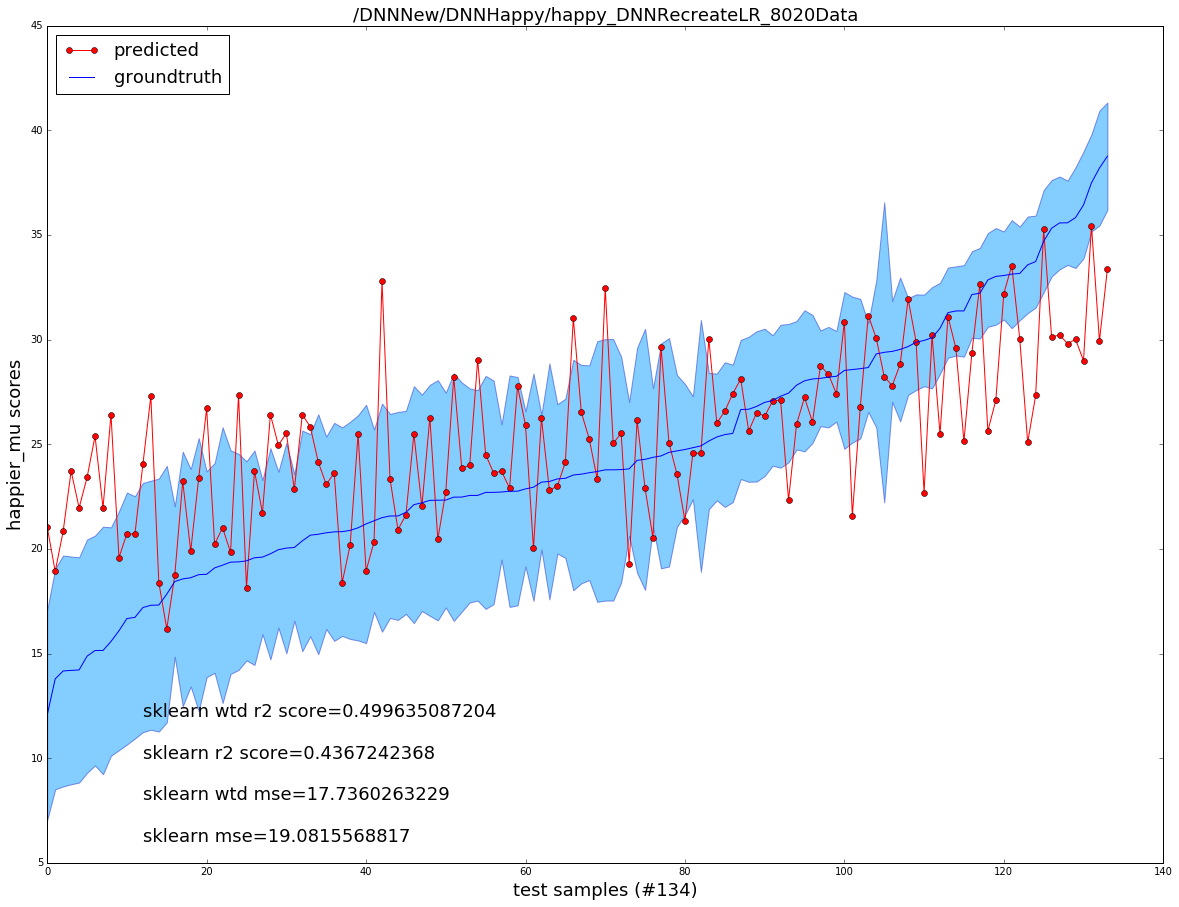

In [21]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_sorted[predicted_name].size, 1)

plt.errorbar(x,y_all_sorted[predicted_name].values,fmt='r-o',label="predicted")
plt.fill_between(x, y_all_sorted[LABEL].values-y_all_sorted[EMOCONFIDENCE_INV[LABEL_ID]], y_all_sorted[LABEL].values+y_all_sorted[EMOCONFIDENCE_INV[LABEL_ID]],
    alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.errorbar(x,y_all_sorted[LABEL].values,fmt='b',label="groundtruth")

plt.title(model_dir_name,fontsize=18)
plt.xlabel('test samples (#'+str(y_test[LABEL].size)+')',fontsize=18)
plt.ylabel(LABEL +' scores',fontsize=18)
pylab.legend(loc='upper left', fontsize=18)
plt.text(12,12, 'sklearn wtd r2 score='+str(r2_score_wtd), fontsize=18)
plt.text(12,10, 'sklearn r2 score='+str(r2_score), fontsize=18)
plt.text(12,8, 'sklearn wtd mse='+str(score_sklearn_wtd), fontsize=18)
plt.text(12,6, 'sklearn mse='+str(score_sklearn), fontsize=18)
plt.show()
fig_name = model_dir_name + "/testPrediction.pdf"
ax.savefig(fig_name) 

In [22]:
predicted_name_train ="predicted_"+LABEL+"_train"
y_hat_train = pd.DataFrame(y_predicted_train, columns=[predicted_name_train], index=y_train[LABEL].index) 
y_all_train = pd.concat([y_hat_train, y_train[LABEL], y_train[EMOCONFIDENCE_INV[LABEL_ID]]], axis=1)
y_all_sorted_train = y_all_train.sort_values(EMOSCORES[LABEL_ID],ascending=[True])

Populating the interactive namespace from numpy and matplotlib


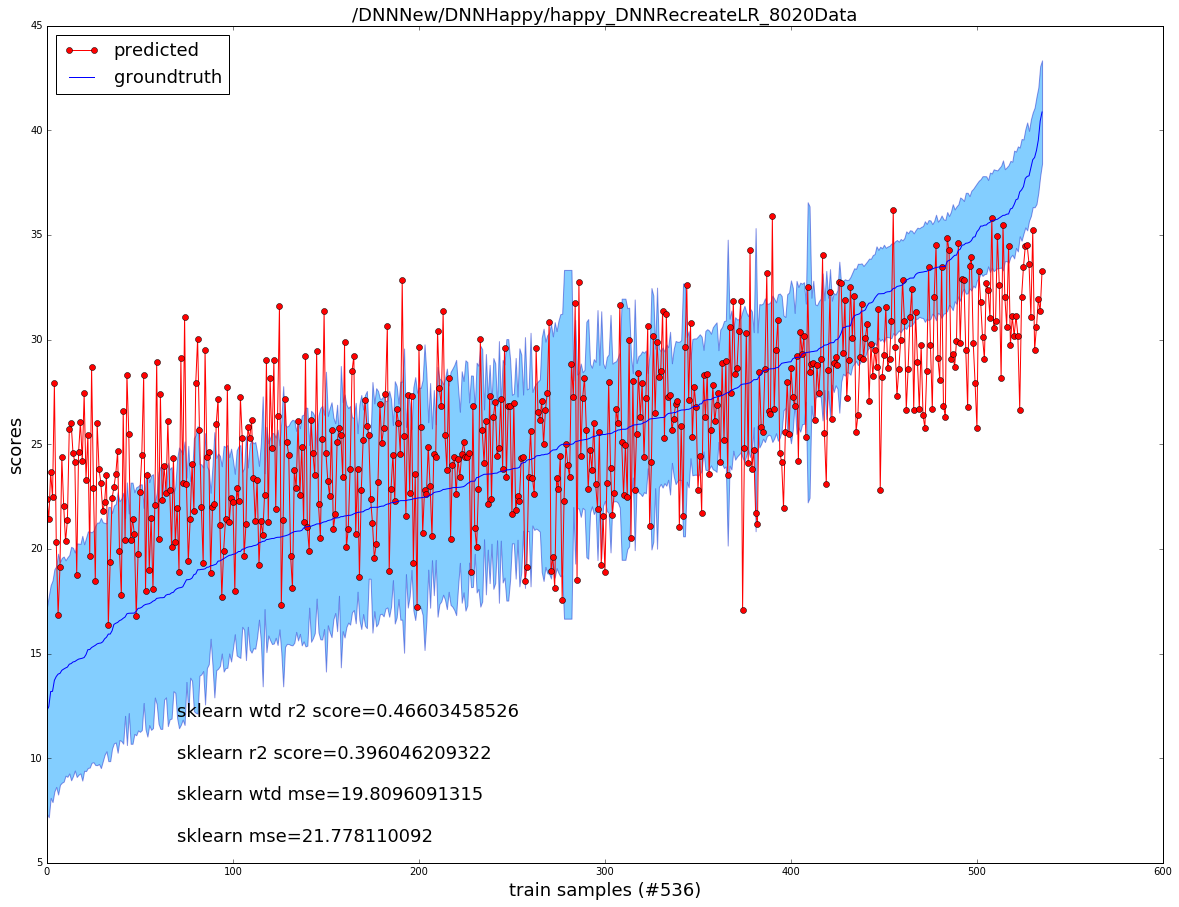

In [23]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_sorted_train[predicted_name_train].size, 1)

plt.errorbar(x,y_all_sorted_train[predicted_name_train].values,fmt='r-o',label="predicted")
plt.fill_between(x, y_all_sorted_train[LABEL].values-y_all_sorted_train[EMOCONFIDENCE_INV[LABEL_ID]], y_all_sorted_train[LABEL].values+y_all_sorted_train[EMOCONFIDENCE_INV[LABEL_ID]],
    alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.errorbar(x,y_all_sorted_train[LABEL].values,fmt='b',label="groundtruth")

plt.title(model_dir_name,fontsize=18)
plt.xlabel('train samples (#'+str(y_train[LABEL].size)+')',fontsize=18)
plt.ylabel('scores',fontsize=18)
pylab.legend(loc='upper left', fontsize=18)
plt.text(70,12, 'sklearn wtd r2 score='+str(r2_score_wtd_train), fontsize=18)
plt.text(70,10, 'sklearn r2 score='+str(r2_score_train), fontsize=18)
plt.text(70,8, 'sklearn wtd mse='+str(score_sklearn_wtd_train), fontsize=18)
plt.text(70,6, 'sklearn mse='+str(score_sklearn_train), fontsize=18)
plt.show()
fig_name = model_dir_name + "/trainPrediction.pdf"
ax.savefig(fig_name) 

In [38]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [39]:
mapperLR = DataFrameMapper([
...     (["bodyAngleZ", "frontKneesAngle", "rearKneesAngle", "frontAnkle", "rearAnkle", "frontHipsAngle", "rearHipsAngle", "swingFtHeight", "speed", "gaitDuration"], preprocessing.StandardScaler()),
...     (['FFPType'], preprocessing.OneHotEncoder())], input_df = True, sparse = True)

In [40]:
transformedDataLR = mapperLR.fit_transform(data.copy())

In [41]:
scores_WTS = pd.concat([scores, WTS_df], axis = 1)

In [42]:
 X_trainLR, X_testLR, y_trainLR, y_testLR = model_selection.train_test_split(transformedDataLR, scores_WTS, test_size=0.2, random_state=42)

In [43]:
lr.fit(X_trainLR, y_trainLR[EMOSCORES[LABEL_ID]],sample_weight=y_trainLR[WTS_LABEL[LABEL_ID]])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [44]:
ytest_pred_lr=lr.predict(X_testLR)
ytrain_pred_lr=lr.predict(X_trainLR)

In [45]:
print("Mean squared error LR wtd (test): %.2f"
      % metrics.mean_squared_error( y_testLR[EMOSCORES[LABEL_ID]],ytest_pred_lr,sample_weight=y_testLR[WTS_LABEL[LABEL_ID]]))
# Explained variance score: 1 is perfect prediction
print('R2 score LR wtd (test): %.4f' % metrics.r2_score( y_testLR[EMOSCORES[LABEL_ID]],ytest_pred_lr,sample_weight=y_testLR[WTS_LABEL[LABEL_ID]]))

Mean squared error LR wtd (test): 17.74
R2 score LR wtd (test): 0.4995


In [46]:
print("Mean squared error wtd LR (train): %.2f"
      % metrics.mean_squared_error( y_trainLR[EMOSCORES[LABEL_ID]],ytrain_pred_lr,sample_weight=y_trainLR[WTS_LABEL[LABEL_ID]]))
# Explained variance score: 1 is perfect prediction
print('R2 score wtd LR (train): %.2f' % metrics.r2_score( y_trainLR[EMOSCORES[LABEL_ID]],ytrain_pred_lr,sample_weight=y_trainLR[WTS_LABEL[LABEL_ID]]))

Mean squared error wtd LR (train): 19.81
R2 score wtd LR (train): 0.47


In [52]:
y_hat_lr = pd.DataFrame(ytest_pred_lr, columns=[predicted_name], index=y_testLR[LABEL].index) 

y_all_testlr = pd.concat([y_hat_lr, y_testLR[LABEL], y_testLR[EMOCONFIDENCE_INV[LABEL_ID]]], axis=1)

y_all_testlr_sorted = y_all_testlr.sort_values(EMOSCORES[LABEL_ID],ascending=[True])

ytrain_hat_lr = pd.DataFrame(ytrain_pred_lr, columns=[predicted_name_train], index=y_trainLR[LABEL].index) 

y_all_trainlr = pd.concat([ytrain_hat_lr, y_trainLR[LABEL], y_trainLR[EMOCONFIDENCE_INV[LABEL_ID]]], axis=1)

y_all_trainlr_sorted = y_all_trainlr.sort_values(EMOSCORES[LABEL_ID],ascending=[True])

Populating the interactive namespace from numpy and matplotlib


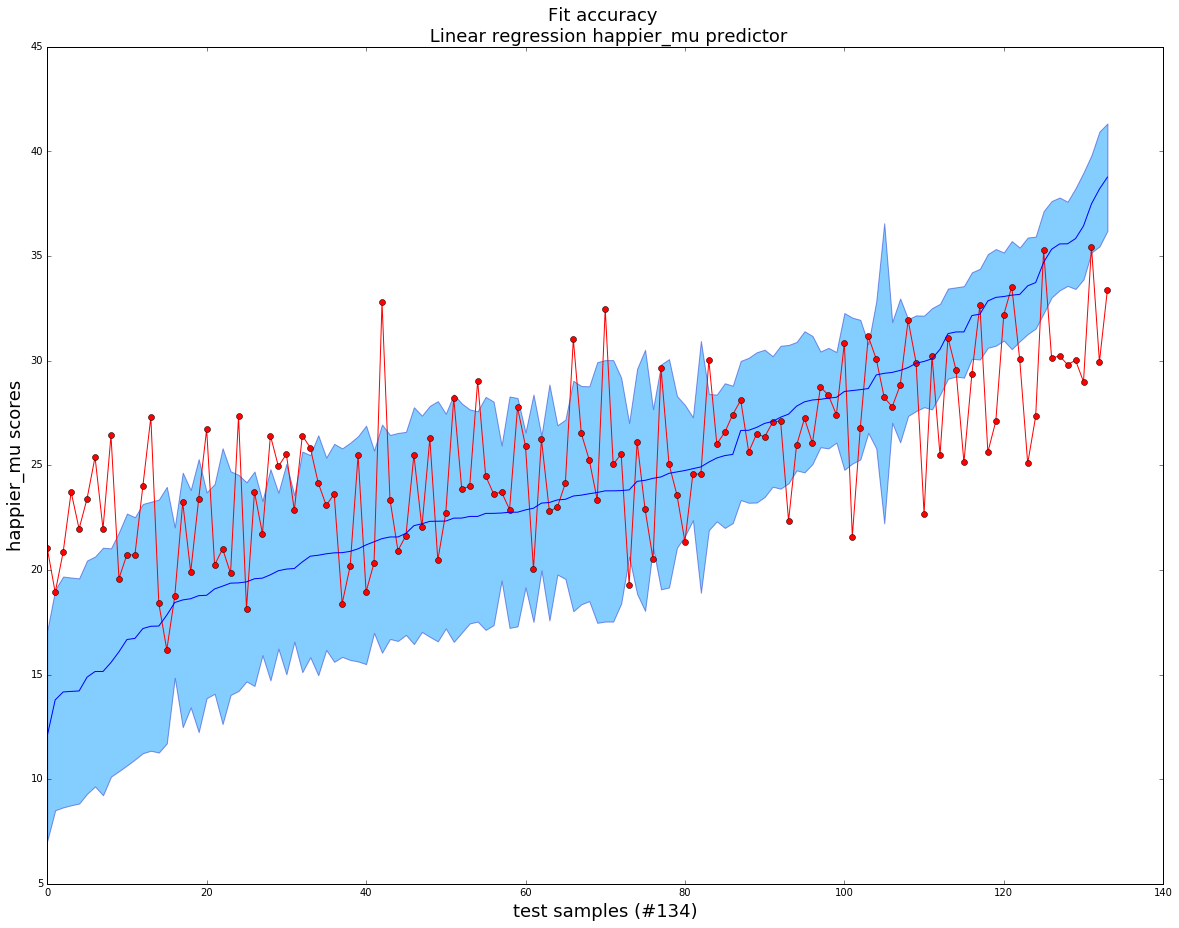

In [53]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_testlr_sorted[predicted_name].size, 1)
plt.errorbar(x,y_all_testlr_sorted[predicted_name].values,fmt='r-o',label="predicted")
plt.fill_between(x, y_all_testlr_sorted[LABEL].values-y_all_testlr_sorted[EMOCONFIDENCE_INV[LABEL_ID]], y_all_testlr_sorted[LABEL].values+y_all_testlr_sorted[EMOCONFIDENCE_INV[LABEL_ID]],
    alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.errorbar(x,y_all_testlr_sorted[LABEL].values,fmt='b',label="groundtruth")
#plt.title(model_dir_name,fontsize=18)
plt.title('Fit accuracy \n Linear regression ' + LABEL + ' predictor',fontsize=18)
plt.xlabel('test samples (#'+str(y_test[LABEL].size)+')',fontsize=18)
plt.ylabel(LABEL +' scores',fontsize=18)
plt.show()

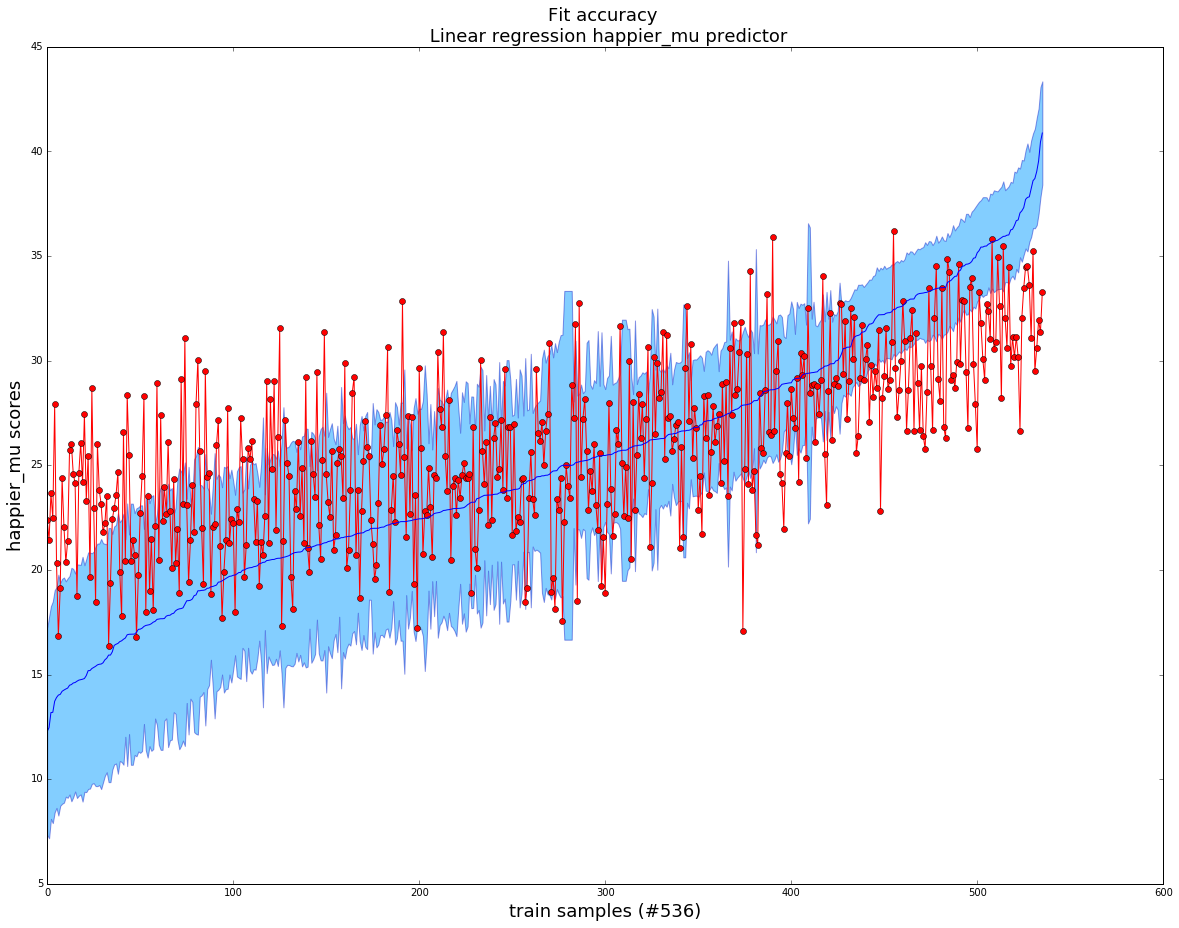

In [54]:
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_trainlr_sorted[predicted_name_train].size, 1)
plt.errorbar(x,y_all_trainlr_sorted[predicted_name_train].values,fmt='r-o',label="predicted")
plt.fill_between(x, y_all_trainlr_sorted[LABEL].values-y_all_trainlr_sorted[EMOCONFIDENCE_INV[LABEL_ID]], y_all_trainlr_sorted[LABEL].values+y_all_trainlr_sorted[EMOCONFIDENCE_INV[LABEL_ID]],
    alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.errorbar(x,y_all_trainlr_sorted[LABEL].values,fmt='b',label="groundtruth")
#plt.title(model_dir_name,fontsize=18)
plt.title('Fit accuracy \n Linear regression ' + LABEL + ' predictor',fontsize=18)
plt.xlabel('train samples (#'+str(y_train[LABEL].size)+')',fontsize=18)
plt.ylabel(LABEL +' scores',fontsize=18)
plt.show()
# fig_name = model_dir_name + "/testPredictionHappyShaded.pdf"
# ax.savefig(fig_name) 